In [1]:
import simpy
import random
import statistics
import math
import numpy as np
import matplotlib.pyplot as plt


def customer(env, server, times):
    arrival_time = env.now
    with server.request() as request:
        yield request
        wait = env.now - arrival_time
        times.append(wait)  # Record waiting time
        service_time = random.expovariate(mu)
        yield env.timeout(service_time)

def setup(env, num_servers, lambda_, mu, times):
    server = simpy.Resource(env, num_servers)

    # Continuously create customers
    while True:
        yield env.timeout(random.expovariate(lambda_))
        env.process(customer(env, server, times))

def confidence_interval(data, confidence=0.95):
    mean = statistics.mean(data)
    stdev = statistics.stdev(data)
    n = len(data)
    z = 1.96  # 95% confidence level
    margin = z * (stdev / math.sqrt(n))
    return mean, margin

lambda_ = 10  # Arrival rate
mu = 5        # Service rate
simulation_time = 10000  # Simulation time

# different numbers of servers
for num_servers in [1, 2, 4]:
    wait_times = []
    random.seed(42)
    env = simpy.Environment()
    env.process(setup(env, num_servers, lambda_, mu, wait_times))
    env.run(until=simulation_time)

    average_wait, margin = confidence_interval(wait_times)
    print(f"\nNumber of servers: {num_servers}, Average waiting time: {average_wait:.2f}")
    print(f"Confidence interval: ({average_wait - margin:.2f}, {average_wait + margin:.2f})")
    print(f"Total number of customers: {len(wait_times)}, Standard deviation: {statistics.stdev(wait_times):.2f}")



Number of servers: 1, Average waiting time: 2478.30
Confidence interval: (2465.72, 2490.88)
Total number of customers: 50138, Standard deviation: 1436.72

Number of servers: 2, Average waiting time: 16.98
Confidence interval: (16.90, 17.05)
Total number of customers: 99441, Standard deviation: 11.42

Number of servers: 4, Average waiting time: 0.02
Confidence interval: (0.02, 0.02)
Total number of customers: 99521, Standard deviation: 0.06


In [2]:
from scipy import stats

def anova_test(data):
    f_value, p_value = stats.f_oneway(data[1], data[2], data[4])
    return f_value, p_value

lambda_ = 10  
mu = 5      
simulation_time = 10000 

wait_times_data = {}

for num_servers in [1, 2, 4]:
    wait_times = []
    random.seed(42)
    env = simpy.Environment()
    env.process(setup(env, num_servers, lambda_, mu, wait_times))
    env.run(until=simulation_time)
    wait_times_data[num_servers] = wait_times

f_value, p_value = anova_test(wait_times_data)
print(f"\nImpact of the number of servers on waiting time - ANOVA test result:")
print(f"F-value: {f_value:.2f}, p-value: {p_value:.4f}")

# Determine whether there is a significant difference
if p_value < 0.05:
    print("Different numbers of servers have a significant impact on waiting time.")
else:
    print("Different numbers of servers do not have a significant impact on waiting time.")



Impact of the number of servers on waiting time - ANOVA test result:
F-value: 293964.73, p-value: 0.0000
Different numbers of servers have a significant impact on waiting time.


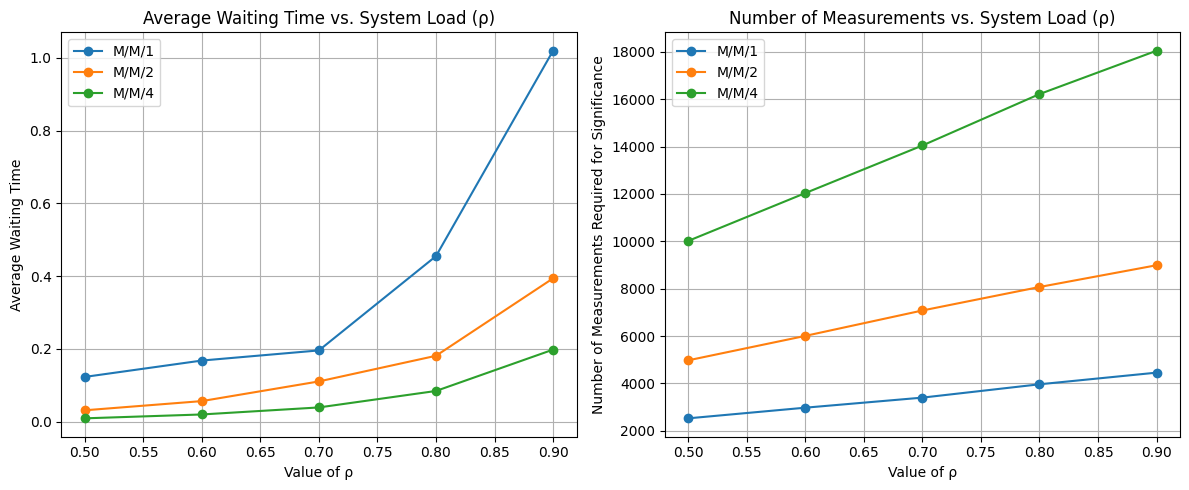

In [3]:
mu = 10       # Service rate
servers = [1, 2, 4]  # Number of servers
rho_values = [0.5, 0.6, 0.7, 0.8, 0.9]  # Different values of ρ
simulation_time = 10000  # Simulation time for each run
increment = 500  # Data point increment

significant_measurements = {n: [] for n in servers}
average_wait_times = {n: [] for n in servers}

for n in servers:
    for rho in rho_values:
        lambda_ = rho * n * mu
        # Determine data points needed for significance
        measurements_needed = None
        for sim_time in range(increment, simulation_time + increment, increment):
            wait_times = []
            random.seed(42)
            env = simpy.Environment()
            env.process(setup(env, n, lambda_, mu, wait_times))
            env.run(until=sim_time)
            if len(wait_times) > 1 and stats.ttest_1samp(wait_times, 0).pvalue < 0.05:
                measurements_needed = len(wait_times)
                break
        significant_measurements[n].append(measurements_needed)
        # Calculate average waiting time
        average_wait = statistics.mean(wait_times)
        average_wait_times[n].append(average_wait)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
for n in servers:
    plt.plot(rho_values, significant_measurements[n], label=f'M/M/{n}', marker='o')
plt.xlabel('Value of ρ')
plt.ylabel('Number of Measurements Required for Significance')
plt.title('Number of Measurements vs. System Load (ρ)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 1)
for n in servers:
    plt.plot(rho_values, average_wait_times[n], label=f'M/M/{n}', marker='o')
plt.xlabel('Value of ρ')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs. System Load (ρ)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Question 3

import simpy
import random
import statistics
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Define the customer process for FIFO scheduling
def customer_fifo(env, server, times):
    arrival_time = env.now
    with server.request() as request:
        yield request
        wait = env.now - arrival_time
        times.append(wait)  # Record waiting time
        service_time = random.expovariate(mu)
        yield env.timeout(service_time)

# Define the setup for FIFO scheduling
def setup_fifo(env, num_servers, lambda_, mu, times):
    server = simpy.Resource(env, num_servers)
    while True:
        yield env.timeout(random.expovariate(lambda_))
        env.process(customer_fifo(env, server, times))

# Define the customer process for SJF scheduling
def customer_sjf(env, server, job_duration, times):
    arrival_time = env.now
    with server.request(priority=job_duration) as request:
        yield request
        wait = env.now - arrival_time
        times.append(wait)
        yield env.timeout(job_duration)

# Define the setup for SJF scheduling
def setup_sjf(env, lambda_, mu, times):
    server = simpy.PriorityResource(env, capacity=1)
    while True:
        job_duration = random.expovariate(mu)
        env.process(customer_sjf(env, server, job_duration, times))
        yield env.timeout(random.expovariate(lambda_))

# Simulation parameters
mu = 10  
simulation_time = 10000 
load_levels = np.linspace(0.1, 0.9, 9)  # System load levels

# Results storage
results_sjf = {'loads': [], 'average_waits': [], 'measurements': [], 'p_values': []}
results_fifo = {'loads': [], 'average_waits': [], 'measurements': [], 'p_values': []}

# Simulate for each load level
for rho in load_levels:
    # FIFO Simulation
    lambda_ = rho * mu  
    wait_times_fifo = []
    random.seed(42)
    env = simpy.Environment()
    env.process(setup_fifo(env, 1, lambda_, mu, wait_times_fifo))
    env.run(until=simulation_time)

    # SJF Simulation
    wait_times_sjf = []
    env = simpy.Environment()
    env.process(setup_sjf(env, lambda_, mu, wait_times_sjf))
    env.run(until=simulation_time)

    # Store results and calculate p-value
    mean_fifo = statistics.mean(wait_times_fifo)
    mean_sjf = statistics.mean(wait_times_sjf)
    p_value = stats.ttest_ind(wait_times_fifo, wait_times_sjf).pvalue

    results_fifo['loads'].append(rho)
    results_fifo['average_waits'].append(mean_fifo)
    results_fifo['measurements'].append(len(wait_times_fifo))
    results_fifo['p_values'].append(p_value)

    results_sjf['loads'].append(rho)
    results_sjf['average_waits'].append(mean_sjf)
    results_sjf['measurements'].append(len(wait_times_sjf))
    results_sjf['p_values'].append(p_value)

# Plotting
plt.figure(figsize=(12, 5))

# Average Waiting Time vs System Load
plt.subplot(1, 2, 1)
plt.plot(results_fifo['loads'], results_fifo['average_waits'], marker='o', label='M/M/1 FIFO')
plt.plot(results_sjf['loads'], results_sjf['average_waits'], marker='o', label='M/M/1 SJF')
plt.xlabel('System Load (ρ)')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs System Load')
plt.legend()

# Number of Measurements vs System Load
plt.subplot(1, 2, 2)
plt.plot(results_fifo['loads'], results_fifo['measurements'], marker='o', label='M/M/1 FIFO')
plt.plot(results_sjf['loads'], results_sjf['measurements'], marker='o', label='M/M/1 SJF')
plt.xlabel('System Load (ρ)')
plt.ylabel('Number of Measurements')
plt.title('Number of Measurements vs System Load')
plt.legend()

plt.tight_layout()
plt.show()

# Optionally, print or plot p-values to analyze the statistical difference in waiting times
for i in range(len(load_levels)):
    print(f"Load {load_levels[i]:.1f}: FIFO vs. SJF p-value = {results_fifo['p_values'][i]:.4f}")
